In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Gensim
from gensim.corpora.dictionary import Dictionary

In [122]:
# Categories
'''
bank_financial_business_review
construction_review
distribution_trade_transport_reviews
education_review
manufacture_chemistry_review
media_design_reviews
organization_association_reviews
medical_medicine_welfare_reviews
service_reviews
'''

'\nbank_financial_business_review\nconstruction_review\ndistribution_trade_transport_reviews\neducation_review\nmanufacture_chemistry_review\nmedia_design_reviews\norganization_association_reviews\nmedical_medicine_welfare_reviews\nservice_reviews\n'

In [123]:
# Read Data

df = pd.read_csv('/Users/myeongseop.kim/Desktop/SCAISCO/csv files/medical_medicine_welfare_reviews.csv')
# 결측치 제거
df = df.dropna()
df.head()

,Unnamed: 0,cmp,adv,dadv
0,0,한미약품(주),연차 사용 자유로움 나이 많은 사람이 적어서 분위기도 자유로움 워라벨이 너무 좋은것...,연장 수당을 주다가 이제 안줘서 다들 책임감이 떨어졌다고 생각됨 급여를 올려주시면 ...
1,1,(주)대웅제약,사유를 묻지 않는 연차사용팀에서도 교육은 적극 권장하고 있어 교육에 참여할 기회가 ...,본인이 성장하는 만큼 일이 많음.평가가 많아서 작성해야 되는 자료가 많음.점심시간 ...
2,2,오스템임플란트(주),명절 선물이 선택할 수 있게 다양하고 직원들을 챙기는 많은 이벤트들이 준비되어 있습...,잦은 야근과 많은 업무량 업무의 종류도 많음 그리고 적응하는 기간이 오래걸릴 것 같...
3,3,(주)종근당,다른업계와 비교했을때 말도안되게 높은 연봉달성했을시 받을 수 있는 인센티브주유비 지...,"쓰잘데기없는 방향으로 자꾸가능 경향이 있음 오늘은 이거집중, 내일은 저거 집중몇개월..."
4,4,삼성바이오로직스(주),"빠른 성장중인 회사. 10년후가 기대되고, 바이오 산업 커리어 시작하기에 최고. 아...","빠른 성장으로 인해 다양한 사람 문제가 많음. 인사팀도 관리하기 힘들어 함. 또한,..."


In [124]:
# # only for it data
# it1 = pd.read_csv('/Users/myeongseop.kim/Desktop/SCAISCO/csv files/it_web_communication_reviews_1_100.csv')
# it2 = pd.read_csv('/Users/myeongseop.kim/Desktop/SCAISCO/csv files/it_web_communication_reviews_101_200.csv')
# it3 = pd.read_csv('/Users/myeongseop.kim/Desktop/SCAISCO/csv files/it_web_communication_reviews_201_300.csv')
# it4 = pd.read_csv('/Users/myeongseop.kim/Desktop/SCAISCO/csv files/it_web_communication_reviews_300_end.csv')

# df= pd.concat([it1,it2,it3,it4],axis=0)
# df.index= [i for i in range(563)]
# # 결측치 제거
# df = df.dropna()
# adv = df['adv'] # Advantage review
# dadv = df['dadv'] # Disadvantage review
# df.head()

In [125]:
# Word Count
from konlpy.tag import Okt

t = Okt()

def my_tokenizer(doc):
    return [
        token
        for token, pos in t.pos(doc)
        if pos == 'Noun' and len(token)>1
    ]

In [126]:
texts = [my_tokenizer(text) for text in df.dadv]

In [127]:
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:',len(dictionary))

dictionary.filter_extremes(keep_n = 2000, no_below = 10, no_above = 0.5)
print("#Number of unique words after removing rae and common words:", len(dictionary))

corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 8220
#Number of unique words after removing rae and common words: 1259
#Number of unique tokens: 1259
#Number of documents: 182


In [128]:
from gensim.models import LdaModel

num_topics = 3
passes = 5
model = LdaModel(corpus = corpus, id2word = dictionary,passes = passes, num_topics = num_topics,random_state = 7)

In [129]:
print(model.print_topics(num_words=10))
# print('#topic distribution of the first document:',model.get_document_topics(corpus)[0])

[(0, '0.008*"생산" + 0.006*"휴가" + 0.006*"위치" + 0.005*"매출" + 0.005*"업계" + 0.005*"경영" + 0.005*"차이" + 0.005*"중간" + 0.005*"제품" + 0.004*"부바"'), (1, '0.010*"병원" + 0.009*"생산" + 0.009*"계약" + 0.007*"정규직" + 0.005*"임금" + 0.005*"승률" + 0.005*"주말" + 0.004*"공장" + 0.004*"신규" + 0.004*"환자"'), (2, '0.010*"회의" + 0.010*"대표" + 0.005*"매출" + 0.005*"코로나" + 0.005*"실무" + 0.005*"미래" + 0.004*"가족" + 0.004*"상사" + 0.004*"회장" + 0.004*"문서"')]


In [130]:
# # topic_modeling csv file
# num_topic_list = [8, 11, 15]
# save = {}
# for i in num_topic_list:
#     model = LdaModel(corpus = corpus, id2word = dictionary,passes = passes, num_topics = i,random_state = 7)
#     save[i] = model.print_topics(num_words=10)
# topic_csv = pd.DataFrame.from_dict(save, orient='index')
# topic_csv.to_csv("it_topic_selection.csv")

In [131]:
# 결과물 코딩
output_df = pd.DataFrame({'cmp':df.cmp})
for col in range(num_topics):
    tmp = str(col)
    output_df[tmp] = float(0)
output_df.index = [i for i in range(len(output_df))]
output_df

,cmp,0,1,2
0,한미약품(주),0.0,0.0,0.0
1,(주)대웅제약,0.0,0.0,0.0
2,오스템임플란트(주),0.0,0.0,0.0
3,(주)종근당,0.0,0.0,0.0
4,삼성바이오로직스(주),0.0,0.0,0.0
...,...,...,...,...
177,애니젠(주),0.0,0.0,0.0
178,코오롱제약(주),0.0,0.0,0.0
179,(주)비보존제약,0.0,0.0,0.0
180,(주)제뉴원사이언스,0.0,0.0,0.0


In [132]:
# 결과물 코딩
# print((model.get_document_topics(corpus)[0][0][1]))

for i, dt in enumerate(model.get_document_topics(corpus)):
    for val in dt:

        idx = str(val[0])
        pt = val[1]

        output_df.at[i,idx] = pt

In [133]:
# to csv file
# output_df.to_csv('construction_topic_modeling.csv')

In [134]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model= model, corpus= corpus, coherence= 'u_mass')
coherence = cm.get_coherence()
print(coherence)

-0.7249009490968871


num_topics: 3, perplexity: -6.949, coherence: -0.630
num_topics: 4, perplexity: -7.003, coherence: -0.685
num_topics: 5, perplexity: -7.056, coherence: -0.697
num_topics: 6, perplexity: -7.103, coherence: -0.672
num_topics: 7, perplexity: -7.157, coherence: -0.700
num_topics: 8, perplexity: -7.208, coherence: -0.686
num_topics: 9, perplexity: -7.260, coherence: -0.666
num_topics: 10, perplexity: -7.310, coherence: -0.686
num_topics: 11, perplexity: -7.364, coherence: -0.679
num_topics: 12, perplexity: -7.419, coherence: -0.684
num_topics: 13, perplexity: -7.466, coherence: -0.704
num_topics: 14, perplexity: -7.521, coherence: -0.702
num_topics: 15, perplexity: -7.571, coherence: -0.686
num_topics: 16, perplexity: -7.635, coherence: -0.709
num_topics: 17, perplexity: -7.674, coherence: -0.678
num_topics: 18, perplexity: -7.726, coherence: -0.686
num_topics: 19, perplexity: -7.783, coherence: -0.697
num_topics: 20, perplexity: -7.829, coherence: -0.703
num_topics: 21, perplexity: -7.878,

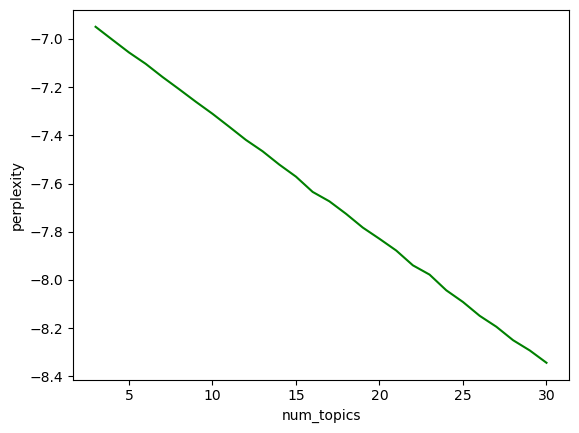

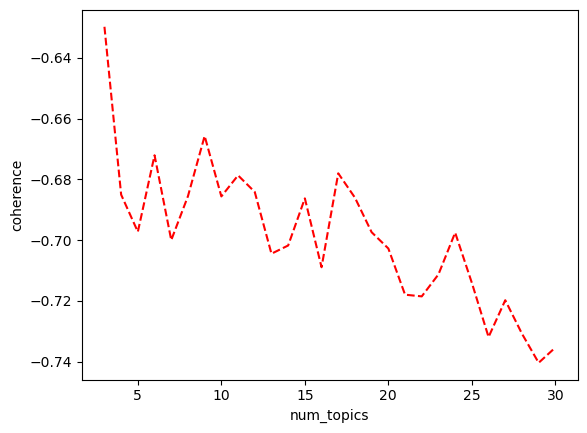

In [135]:
def show_coherence(corpus, dictionary, start = 6, end = 15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end+1):
        model = LdaModel(corpus = corpus, id2word = dictionary, chunksize=1000, num_topics = i,random_state = 7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)

        cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')
    
    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()
# 5, 14
show_coherence(corpus, dictionary, start = 3, end = 30)